In [1]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
bld = pd.read_csv('building_info.csv')
smp = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:


# Rename columns
bld.rename(columns={
    "건물번호": "Building Number",
    "건물유형": "Building Type",
    "연면적(m2)": "Total Floor Area (m²)",
    "냉방면적(m2)": "Air-conditioned Area (m²)",
    "태양광용량(kW)": "Solar Power Capacity (kW)",
    "ESS저장용량(kWh)": "ESS Storage Capacity (kWh)",
    "PCS용량(kW)": "PCS Capacity (kW)"
}, inplace=True)
building_type_map = {
    '호텔': 'Hotel',
    '상용': 'Commercial',
    '병원': 'Hospital',
    '학교': 'School',
    '건물기타': 'Other Building',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '백화점': 'Department Store',
    'IDC(전화국)': 'IDC (Telecom Center)',
    '공공': 'Public Facility'
}

bld['Building Type'] = bld['Building Type'].replace(building_type_map)
test.rename(columns={
    
    "건물번호": "Building Number",
    "일시": "Datetime",
    "기온(°C)": "Temperature (°C)",
    "강수량(mm)": "Precipitation (mm)",
    "풍속(m/s)": "Wind Speed (m/s)",
    "습도(%)": "Humidity (%)"
}, inplace=True)

train.rename(columns={
    "건물번호": "Building Number",
    "일시": "Datetime",
    "기온(°C)": "Temperature (°C)",
    "강수량(mm)": "Precipitation (mm)",
    "풍속(m/s)": "Wind Speed (m/s)",
    "습도(%)": "Humidity (%)",
    "일조(hr)": "Sunshine Duration (hr)",
    "일사(MJ/m2)": "Solar Radiation (MJ/m²)",
    "전력소비량(kWh)": "Power Consumption (kWh)"
}, inplace=True)





In [4]:
train['Datetime'] = pd.to_datetime(train['Datetime'])
train['Hour'] = train['Datetime'].dt.hour
train['Day'] = train['Datetime'].dt.day


In [5]:
test['Datetime'] = pd.to_datetime(test['Datetime'])
test['Hour'] = test['Datetime'].dt.hour
test['Day'] = test['Datetime'].dt.day

In [6]:
train = train.merge(bld[['Building Number','Air-conditioned Area (m²)', 'Total Floor Area (m²)', 'Building Type', 'Solar Power Capacity (kW)', 'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)']], on='Building Number', how='left')

In [7]:
train = train.replace('-', 0)
train.head()

,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Power Consumption (kWh),Hour,Day,Air-conditioned Area (m²),Total Floor Area (m²),Building Type,Solar Power Capacity (kW),ESS Storage Capacity (kWh),PCS Capacity (kW)
0,1_20240601 00,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80,0,1,77586.0,82912.71,Hotel,0,0,0
1,1_20240601 01,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.0,5591.85,1,1,77586.0,82912.71,Hotel,0,0,0
2,1_20240601 02,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.0,5338.17,2,1,77586.0,82912.71,Hotel,0,0,0
3,1_20240601 03,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.0,4554.42,3,1,77586.0,82912.71,Hotel,0,0,0
4,1_20240601 04,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.0,3602.25,4,1,77586.0,82912.71,Hotel,0,0,0


In [8]:
train['Sunshine Duration (hr)'].value_counts()

Sunshine Duration (hr)
0.0    122847
1.0     30856
0.9      7444
0.1      6491
0.8      5716
0.2      5398
0.7      5362
0.6      5231
0.3      5018
0.5      4923
0.4      4714
Name: count, dtype: int64

In [9]:
test = test.merge(bld[['Building Number','Air-conditioned Area (m²)', 'Total Floor Area (m²)', 'Building Type', 'Solar Power Capacity (kW)', 'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)']], on='Building Number', how='left')
test = test.replace('-', 0)
test.head()

,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Hour,Day,Air-conditioned Area (m²),Total Floor Area (m²),Building Type,Solar Power Capacity (kW),ESS Storage Capacity (kWh),PCS Capacity (kW)
0,1_20240825 00,1,2024-08-25 00:00:00,26.5,0.0,0.7,80.0,0,25,77586.0,82912.71,Hotel,0,0,0
1,1_20240825 01,1,2024-08-25 01:00:00,26.1,0.0,0.0,80.0,1,25,77586.0,82912.71,Hotel,0,0,0
2,1_20240825 02,1,2024-08-25 02:00:00,25.9,0.0,0.3,83.0,2,25,77586.0,82912.71,Hotel,0,0,0
3,1_20240825 03,1,2024-08-25 03:00:00,25.7,0.0,1.1,83.0,3,25,77586.0,82912.71,Hotel,0,0,0
4,1_20240825 04,1,2024-08-25 04:00:00,25.5,0.0,1.0,86.0,4,25,77586.0,82912.71,Hotel,0,0,0


In [10]:
bld.head()

,Building Number,Building Type,Total Floor Area (m²),Air-conditioned Area (m²),Solar Power Capacity (kW),ESS Storage Capacity (kWh),PCS Capacity (kW)
0,1,Hotel,82912.71,77586.00,-,-,-
1,2,Commercial,40658.90,30392.82,-,-,-
2,3,Hospital,560431.00,418992.00,278.58,-,-
3,4,Hotel,41813.29,23715.71,-,-,-
4,5,School,403749.39,248507.00,1983.05,1025,250


In [11]:
bld.isna().sum()

Building Number               0
Building Type                 0
Total Floor Area (m²)         0
Air-conditioned Area (m²)     0
Solar Power Capacity (kW)     0
ESS Storage Capacity (kWh)    0
PCS Capacity (kW)             0
dtype: int64

In [12]:
train['Building Type'].unique()

array(['Hotel', 'Commercial', 'Hospital', 'School', 'Other Building',
       'Apartment', 'Research Institute', 'Department Store',
       'IDC (Telecom Center)', 'Public Facility'], dtype=object)

In [13]:
import pandas as pd
import numpy as np

def prepare_features(train_df, test_df):
    # Combine train + test for lag/rolling calculations
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    full_df = pd.concat([train_df, test_df], ignore_index=True)

    # Ensure datetime is proper
    full_df['Datetime'] = pd.to_datetime(full_df['Datetime'])
    full_df['Hour'] = full_df['Datetime'].dt.hour
    
    # -------- Time-based features --------
    full_df['DayOfWeek'] = full_df['Datetime'].dt.weekday
    full_df['Day'] = full_df['Datetime'].dt.day
    full_df['Month'] = full_df['Datetime'].dt.month
    full_df['Week'] = full_df['Datetime'].dt.isocalendar().week.astype(int)
    full_df['is_weekend'] = (full_df['DayOfWeek'] >= 5).astype(int)

    # Cyclic encoding (Hour, DayOfWeek, Day, Month, Week)
    full_df['Hour_sin'] = np.sin(2 * np.pi * full_df['Hour']/24)
    full_df['Hour_cos'] = np.cos(2 * np.pi * full_df['Hour']/24)
    full_df['DayOfWeek_sin'] = np.sin(2 * np.pi * full_df['DayOfWeek']/7)
    full_df['DayOfWeek_cos'] = np.cos(2 * np.pi * full_df['DayOfWeek']/7)
    full_df['Day_sin'] = np.sin(2 * np.pi * full_df['Day']/31)
    full_df['Day_cos'] = np.cos(2 * np.pi * full_df['Day']/31)
    full_df['Month_sin'] = np.sin(2 * np.pi * full_df['Month']/12)
    full_df['Month_cos'] = np.cos(2 * np.pi * full_df['Month']/12)
    full_df['Week_sin'] = np.sin(2 * np.pi * full_df['Week']/52)
    full_df['Week_cos'] = np.cos(2 * np.pi * full_df['Week']/52)

    # -------- Time-of-day one-hot features --------
    def time_of_day(hour):
        if 0 <= hour < 6:
            return "Late_Night"
        elif 6 <= hour < 8:
            return "Early_Morning"
        elif 8 <= hour < 16:
            return "Daytime"
        elif 16 <= hour < 20:
            return "Evening"
        else:
            return "Night"

    full_df['TimeOfDay'] = full_df['Hour'].apply(time_of_day)
    full_df = pd.get_dummies(full_df, columns=['TimeOfDay'], prefix='is', dtype=int)

    # -------- Numeric conversions --------
    cols_to_convert = ['Solar Power Capacity (kW)', 'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)',
                       'Precipitation (mm)', 'Temperature (°C)', 'Wind Speed (m/s)', 'Solar Radiation (MJ/m²)']
    for col in cols_to_convert:
        if col in full_df.columns:
            full_df[col] = pd.to_numeric(full_df[col].astype(str).str.strip(), errors='coerce').fillna(0)

    # -------- Derived weather categories --------
    full_df['is_rain_light'] = ((full_df['Precipitation (mm)'] > 0) & (full_df['Precipitation (mm)'] <= 2)).astype(int)
    full_df['is_rain_moderate'] = ((full_df['Precipitation (mm)'] > 2) & (full_df['Precipitation (mm)'] <= 10)).astype(int)
    full_df['is_rain_heavy'] = (full_df['Precipitation (mm)'] > 10).astype(int)
    full_df['is_cold'] = (full_df['Temperature (°C)'] < 10).astype(int)
    full_df['is_mild'] = ((full_df['Temperature (°C)'] >= 10) & (full_df['Temperature (°C)'] < 25)).astype(int)
    full_df['is_hot'] = (full_df['Temperature (°C)'] >= 25).astype(int)
    full_df['is_calm'] = (full_df['Wind Speed (m/s)'] < 1.5).astype(int)
    full_df['is_breezy'] = ((full_df['Wind Speed (m/s)'] >= 1.5) & (full_df['Wind Speed (m/s)'] < 5)).astype(int)
    full_df['is_windy'] = ((full_df['Wind Speed (m/s)'] >= 5) & (full_df['Wind Speed (m/s)'] < 10)).astype(int)
    full_df['is_stormy'] = (full_df['Wind Speed (m/s)'] >= 10).astype(int)
    full_df['is_low_rad'] = (full_df['Solar Radiation (MJ/m²)'] < 200).astype(int)
    full_df['is_medium_rad'] = ((full_df['Solar Radiation (MJ/m²)'] >= 200) & (full_df['Solar Radiation (MJ/m²)'] < 600)).astype(int)
    full_df['is_high_rad'] = (full_df['Solar Radiation (MJ/m²)'] >= 600).astype(int)

    # -------- Korean holiday encoding --------
    korean_holidays = pd.to_datetime([
        "2024-06-06", # Memorial Day
        "2024-08-15"  # Liberation Day
    ])
    full_df["is_holiday"] = full_df["Datetime"].dt.normalize().isin(korean_holidays).astype(int)

    # -------- Interaction features --------
    # Weather × Energy
    full_df["Solar_Temp"] = full_df["Solar Power Capacity (kW)"] * full_df["Temperature (°C)"]
    full_df["Solar_Humidity"] = full_df["Solar Power Capacity (kW)"] * full_df["Humidity (%)"]
    full_df["Solar_Wind"] = full_df["Solar Power Capacity (kW)"] * full_df["Wind Speed (m/s)"]
    full_df["Temp_Humidity"] = full_df["Temperature (°C)"] * full_df["Humidity (%)"]

    # Time × Weather
    full_df["Temp_Hour_sin"] = full_df["Temperature (°C)"] * full_df["Hour_sin"]
    full_df["Temp_Day_sin"] = full_df["Temperature (°C)"] * full_df["DayOfWeek_sin"]
    full_df["Humidity_Hour_sin"] = full_df["Humidity (%)"] * full_df["Hour_sin"]

    # Holiday × Energy
    full_df["Holiday_Temp"] = full_df["is_holiday"] * full_df["Temperature (°C)"]
    full_df["Holiday_Solar"] = full_df["is_holiday"] * full_df["Solar Power Capacity (kW)"]
    full_df["Holiday_Hour"] = full_df["is_holiday"] * full_df["Hour_sin"]

    # Nonlinear features
    full_df["Temp2"] = full_df["Temperature (°C)"] ** 2
    full_df["Humidity2"] = full_df["Humidity (%)"] ** 2
    full_df["Solar2"] = full_df["Solar Power Capacity (kW)"] ** 2

    # -------- Lag & Rolling features --------
    windows = [24, 72, 168]  # hourly data
    for w in windows:
        full_df[f'RollingMean_{w}h'] = (
            full_df.groupby('Building Number')['Power Consumption (kWh)']
            .shift(1)
            .rolling(w)
            .mean()
            .reset_index(level=0, drop=True)
        )
        full_df[f'RollingStd_{w}h'] = (
            full_df.groupby('Building Number')['Power Consumption (kWh)']
            .shift(1)
            .rolling(w)
            .std()
            .reset_index(level=0, drop=True)
        )
        full_df[f'RollingMedian_{w}h'] = (
            full_df.groupby('Building Number')['Power Consumption (kWh)']
            .shift(1)
            .rolling(w)
            .median()
            .reset_index(level=0, drop=True)
        )

    # EWMA
    full_df['EWMA_24h'] = (
        full_df.groupby('Building Number')['Power Consumption (kWh)']
        .shift(1)
        .ewm(span=24, adjust=False)
        .mean()
    )

    # -------- Split back into train/test --------
    train_processed = full_df[full_df['is_train'] == 1].drop(columns=['is_train'])
    test_processed = full_df[full_df['is_train'] == 0].drop(columns=['is_train', 'Power Consumption (kWh)'], errors='ignore')

    return train_processed, test_processed

train, test = prepare_features(train, test)


In [12]:
train.isna().sum()

num_date_time             0
Building Number           0
Datetime                  0
Temperature (°C)          0
Precipitation (mm)        0
                      ...  
RollingMedian_72h      7200
RollingMean_168h      16800
RollingStd_168h       16800
RollingMedian_168h    16800
EWMA_24h                  1
Length: 74, dtype: int64

In [13]:
train.columns

Index(['num_date_time', 'Building Number', 'Datetime', 'Temperature (°C)',
       'Precipitation (mm)', 'Wind Speed (m/s)', 'Humidity (%)',
       'Sunshine Duration (hr)', 'Solar Radiation (MJ/m²)',
       'Power Consumption (kWh)', 'Hour', 'Day', 'Air-conditioned Area (m²)',
       'Total Floor Area (m²)', 'Building Type', 'Solar Power Capacity (kW)',
       'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)', 'DayOfWeek', 'Month',
       'Week', 'is_weekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos',
       'Week_sin', 'Week_cos', 'is_Daytime', 'is_Early_Morning', 'is_Evening',
       'is_Late_Night', 'is_Night', 'is_rain_light', 'is_rain_moderate',
       'is_rain_heavy', 'is_cold', 'is_mild', 'is_hot', 'is_calm', 'is_breezy',
       'is_windy', 'is_stormy', 'is_low_rad', 'is_medium_rad', 'is_high_rad',
       'is_holiday', 'Solar_Temp', 'Solar_Humidity', 'Solar_Wind',
       'Temp_Humidity', 'Temp_Hour_sin', 'Tem

In [14]:
train = train.replace('NaN', 0)

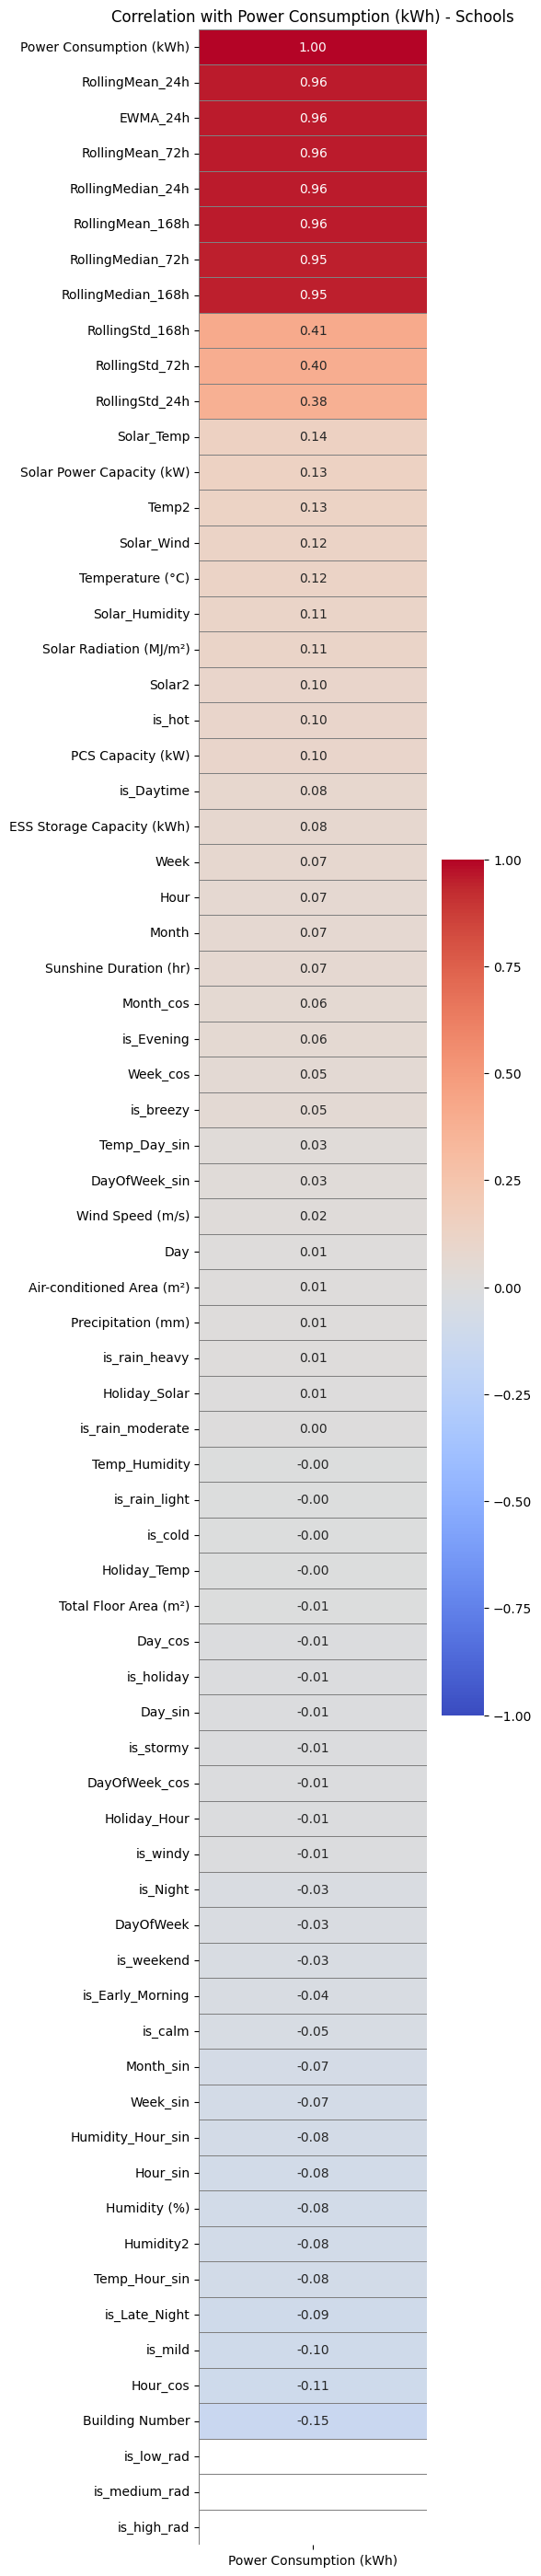

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix (numeric only)
corr_matrix = train.corr(numeric_only=True)

# Select the row of correlations with 'Power Consumption (kWh)'
corr_with_power = corr_matrix[['Power Consumption (kWh)']].sort_values(by='Power Consumption (kWh)', ascending=False)

plt.figure(figsize=(4, len(corr_with_power)*0.5))  # Adjust height to number of features

sns.heatmap(
    corr_with_power,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    fmt=".2f"
)

plt.title('Correlation with Power Consumption (kWh) - Schools')
plt.show()


In [16]:
train.head()

,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Power Consumption (kWh),...,RollingMean_24h,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h
0,1_20240601 00,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1_20240601 01,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.0,5591.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5794.800000
2,1_20240601 02,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.0,5338.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5778.564000
3,1_20240601 03,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.0,4554.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5743.332480
4,1_20240601 04,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.0,3602.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5648.219482


In [21]:
import pandas as pd
import numpy as np

# # Load your data (assuming 'Datetime' is in a parseable format)
# train = pd.read_csv('train.csv')
# train['Datetime'] = pd.to_datetime(train['Datetime'], format='%m%d %H:%M')  # Adjust format if needed

# Verify date range (optional, for debugging)
print(train['Datetime'].min())  # Should be around 2025-06-01 00:00
print(train['Datetime'].max())  # Should be around 2025-08-24 23:00

# Loop over each building and remove outliers using IQR method
for building in train['Building Number'].unique():
    # Filter data for the current building
    building_data = train[train['Building Number'] == building]
    
    # Ensure the data covers the full range (0601 to 0824)
    expected_hours = pd.date_range(start='2025-06-01 00:00', end='2025-08-24 23:00', freq='H')
    if len(building_data) != len(expected_hours):
        print(f"Warning: Building {building} has {len(building_data)} entries, expected {len(expected_hours)}")
        # Optionally interpolate missing hours, but for now, proceed with available data
    
    # Calculate Q1, Q3, and IQR for 'Power Consumption (kWh)'
    Q1 = building_data['Power Consumption (kWh)'].quantile(0.25)
    Q3 = building_data['Power Consumption (kWh)'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip outliers for the current building
    train.loc[train['Building Number'] == building, 'Power Consumption (kWh)'] = \
        building_data['Power Consumption (kWh)'].clip(lower_bound, upper_bound)



2024-06-01 00:00:00
2024-08-24 23:00:00


C:\Users\Dell\AppData\Local\Temp\ipykernel_33128\1403987891.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start='2025-06-01 00:00', end='2025-08-24 23:00', freq='H')
C:\Users\Dell\AppData\Local\Temp\ipykernel_33128\1403987891.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start='2025-06-01 00:00', end='2025-08-24 23:00', freq='H')
C:\Users\Dell\AppData\Local\Temp\ipykernel_33128\1403987891.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start='2025-06-01 00:00', end='2025-08-24 23:00', freq='H')
C:\Users\Dell\AppData\Local\Temp\ipykernel_33128\1403987891.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start='2025-06-01 00:00', en

In [17]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== sMAPE function =====
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100

# ===== Features & target =====
features = [
    'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
    'is_weekend', 'is_Daytime', 'is_Early_Morning', 'is_Evening', 'is_Late_Night', 'is_Night',
    'Wind Speed (m/s)', 'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'Solar Power Capacity (kW)',
    'DayOfWeek_sin', 'DayOfWeek_cos', 'is_holiday',
    'Solar_Temp', 'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity',
    'Temp_Hour_sin', 'Temp_Day_sin', 'Humidity_Hour_sin', 'Holiday_Temp',
    'Holiday_Solar', 'Holiday_Hour', 'Temp2', 'Humidity2', 
    'Hour_sin', 'Hour_cos'
]
target = 'Power Consumption (kWh)'

# ===== Parameter grid =====
param_grid = {
    'n_estimators': [300,400, 500],
    'learning_rate': [0.09, 0.1],
    'num_leaves': [98, 150, 200]
}

# ===== Dictionary to store results =====
building_types = train['Building Type'].unique()
results = {}

for b_type in building_types:
    print(f"\n=== Training for Building Type: {b_type} ===")
    
    train_bld = train[train['Building Type'] == b_type]
    
    if train_bld.empty:
        print(f"Skipping {b_type}, no data in train.")
        continue
    
    # ===== Train-validation split =====
    X_train, X_val, y_train, y_val = train_test_split(
        train_bld[features], train_bld[target], test_size=0.1, random_state=42
    )
    
    best_rmse = np.inf
    best_model = None
    best_params = None
    
    # ===== Grid search =====
    for params in ParameterGrid(param_grid):
        model = lgb.LGBMRegressor(
            boosting_type='gbdt',
            n_estimators=params['n_estimators'],
            learning_rate=params['learning_rate'],
            num_leaves=params['num_leaves'],
            random_state=42
        )
        
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params
    
    # ===== Evaluate best model =====
    y_pred = best_model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val, y_pred) * 100
    smape_val = smape(y_val, y_pred)
    
    print(f"Best params: {best_params}")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAPE: {mape:.2f}%, sMAPE: {smape_val:.2f}%")
    
    # ===== Store results =====
    results[b_type] = {
        'model': best_model,
        'params': best_params,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'smape': smape_val,
        'feature_importance': pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
    }



=== Training for Building Type: Hotel ===
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the train set: 18360, number of used features: 28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3171.821125
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the t

In [14]:
train_school = train[train['Building Type'] == 'School']


# train_com = train.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 'Building Type']],
#     on='Building Number',
#     how='left'
# )
train_com = train[train['Building Type'] == 'Commercial']

# train_hospital = train.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 'Building Type']],
#     on='Building Number',
#     how='left'
# )
train_hospital = train[train['Building Type'] == 'Hospital']

# train_other = train.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 'Building Type']],
#     on='Building Number',
#     how='left'
# )
train_other = train[train['Building Type'] == 'Other Building']

# train_apartment = train.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 'Building Type']],
#     on='Building Number',
#     how='left'
# )
train_apartment = train[train['Building Type'] == 'Apartment']

# train_research = train.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 'Building Type']],
#     on='Building Number',
#     how='left'
# )
train_research = train[train['Building Type'] == 'Research Institute']

# train_department = train.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 'Building Type']],
#     on='Building Number',
#     how='left'
# )
train_department = train[train['Building Type'] == 'Department Store']

# train_idc = train.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 'Building Type']],
#     on='Building Number',
#     how='left'
# )
train_idc = train[train['Building Type'] == 'IDC (Telecom Center)']

# train_public = train.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)', 'Building Type']],
#     on='Building Number',
#     how='left'
# )
train_public = train[train['Building Type'] == 'Public Facility']

train_hotel = train[train['Building Type'] == 'Hotel']

test_school = test[test['Building Type'] == 'School']

# test_com = test.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)','Building Type']],
#     on='Building Number',
#     how='left'
# )
test_com = test[test['Building Type'] == 'Commercial']

# test_hospital = test.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)','Building Type']],
#     on='Building Number',
#     how='left'
# )
test_hospital = test[test['Building Type'] == 'Hospital']

# test_other = test.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)','Building Type']],
#     on='Building Number',
#     how='left'
# )
test_other = test[test['Building Type'] == 'Other Building']

# test_apartment = test.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)','Building Type']],
#     on='Building Number',
#     how='left'
# )
test_apartment = test[test['Building Type'] == 'Apartment']

# test_research = test.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)','Building Type']],
#     on='Building Number',
#     how='left'
# )
test_research = test[test['Building Type'] == 'Research Institute']

# test_department = test.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)','Building Type']],
#     on='Building Number',
#     how='left'
# )
test_department = test[test['Building Type'] == 'Department Store']

# test_idc = test.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)','Building Type']],
#     on='Building Number',
#     how='left'
# )
test_idc = test[test['Building Type'] == 'IDC (Telecom Center)']

# test_public = test.merge(
#     bld[['Building Number', 'Total Floor Area (m²)', 'Air-conditioned Area (m²)','Building Type']],
#     on='Building Number',
#     how='left'
# )
test_public = test[test['Building Type'] == 'Public Facility']

test_hotel = test[test['Building Type'] == 'Hotel']


In [15]:
train.columns

Index(['num_date_time', 'Building Number', 'Datetime', 'Temperature (°C)',
       'Precipitation (mm)', 'Wind Speed (m/s)', 'Humidity (%)',
       'Sunshine Duration (hr)', 'Solar Radiation (MJ/m²)',
       'Power Consumption (kWh)', 'Hour', 'Day', 'Air-conditioned Area (m²)',
       'Total Floor Area (m²)', 'Building Type', 'Solar Power Capacity (kW)',
       'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)', 'DayOfWeek', 'Month',
       'Week', 'is_weekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos',
       'Week_sin', 'Week_cos', 'is_Daytime', 'is_Early_Morning', 'is_Evening',
       'is_Late_Night', 'is_Night', 'is_rain_light', 'is_rain_moderate',
       'is_rain_heavy', 'is_cold', 'is_mild', 'is_hot', 'is_calm', 'is_breezy',
       'is_windy', 'is_stormy', 'is_low_rad', 'is_medium_rad', 'is_high_rad',
       'is_holiday', 'Solar_Temp', 'Solar_Humidity', 'Solar_Wind',
       'Temp_Humidity', 'Temp_Hour_sin', 'Tem

In [31]:
test.columns

Index(['num_date_time', 'Building Number', 'Datetime', 'Temperature (°C)',
       'Precipitation (mm)', 'Wind Speed (m/s)', 'Humidity (%)',
       'Sunshine Duration (hr)', 'Solar Radiation (MJ/m²)', 'Hour', 'Day',
       'Air-conditioned Area (m²)', 'Total Floor Area (m²)', 'Building Type',
       'Solar Power Capacity (kW)', 'ESS Storage Capacity (kWh)',
       'PCS Capacity (kW)', 'DayOfWeek', 'Month', 'Week', 'is_weekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos',
       'is_Daytime', 'is_Early_Morning', 'is_Evening', 'is_Late_Night',
       'is_Night', 'is_rain_light', 'is_rain_moderate', 'is_rain_heavy',
       'is_cold', 'is_mild', 'is_hot', 'is_calm', 'is_breezy', 'is_windy',
       'is_stormy', 'is_low_rad', 'is_medium_rad', 'is_high_rad', 'is_holiday',
       'Solar_Temp', 'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity',
       'Temp_Hour_sin', 'Temp_Day_sin', 'Humidity_Hour_

In [18]:
features = ['Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
            'is_weekend', 'is_Daytime', 'is_Early_Morning', 'is_Evening', 'is_Late_Night', 'is_Night',
            'Wind Speed (m/s)', 'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)', 'Solar Power Capacity (kW)',
            'DayOfWeek_sin', 'DayOfWeek_cos', 'is_holiday',
            'Solar_Temp', 'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity',
            'Temp_Hour_sin', 'Temp_Day_sin', 'Humidity_Hour_sin', 'Holiday_Temp',
            'Holiday_Solar', 'Holiday_Hour', 'Temp2', 'Humidity2', 'Solar2',
            'Hour_sin', 'Hour_cos', 'Temperature (°C)', 
            'Humidity (%)'
                   ]

In [18]:
# ===== Prepare features & target =====
X = train_school[features]

y = train_school['Power Consumption (kWh)']

# ===== Train-test split =====    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [27]:
train['Building Type'].unique()

array(['Hotel', 'Commercial', 'Hospital', 'School', 'Other Building',
       'Apartment', 'Research Institute', 'Department Store',
       'IDC (Telecom Center)', 'Public Facility'], dtype=object)

In [37]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Define SMAPE ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# --- Get unique buildings in 'Other Building' type ---
unique_buildings = train_public['Building Number'].unique()

# Store results
building_metrics = []

# Loop through each building
for bld_num in unique_buildings:
    bld_train = train_public[train_public['Building Number'] == bld_num]

    # Skip very small datasets
    if len(bld_train) < 30:
        continue

    # === Features & Target ===
    X = bld_train[['Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
            'is_weekend', 'is_Daytime', 'is_Early_Morning', 'is_Evening', 
            'is_Late_Night', 'is_Night', 'Wind Speed (m/s)', 
            'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'Solar Power Capacity (kW)',
            'DayOfWeek_sin', 'DayOfWeek_cos', 'is_holiday', 'Solar_Temp', 
            'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity', 'Temp_Hour_sin', 
            'Temp_Day_sin', 'Humidity_Hour_sin', 'Holiday_Temp', 'Holiday_Solar', 
            'Holiday_Hour', 'Temp2', 'Humidity2', 'Hour_sin', 'Hour_cos']]

    y = bld_train['Power Consumption (kWh)']

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # === LightGBM Model ===
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=500,
        learning_rate=0.1,
        num_leaves=120,
        random_state=42
    )

    # Train model
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    # === Evaluate ===
    y_pred = model.predict(X_val)

    building_smape = smape(y_val.values, y_pred)
    building_mape = mean_absolute_percentage_error(y_val, y_pred) * 100

    building_metrics.append({
        "Building": bld_num,
        "Samples": len(bld_train),
        "SMAPE": building_smape,
        "MAPE": building_mape
    })

# # Convert to DataFrame
metrics_df = pd.DataFrame(building_metrics)
metrics_df = metrics_df.sort_values(by="SMAPE")  # Sort by best models first

# # Save metrics for analysis
# metrics_df.to_csv("other_buildings_metrics.csv", index=False)

print(metrics_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1732
[LightGBM] [Info] Number of data points in the train set: 1632, number of used features: 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1825.550772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [ ]:
train_idc['Building Number'].unique()

# Store results
building_metrics = []

# Loop through each building
for bld_num in unique_buildings:
    bld_train = train_idc[train_idc['Building Number'] == bld_num]

    # Skip very small datasets
    if len(bld_train) < 30:
        continue

    # === Features & Target ===
    X = bld_train[['Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
            'is_weekend', 'is_Daytime', 'is_Early_Morning', 'is_Evening', 
            'is_Late_Night', 'is_Night', 'Wind Speed (m/s)', 
            'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'Solar Power Capacity (kW)',
            'DayOfWeek_sin', 'DayOfWeek_cos', 'is_holiday', 'Solar_Temp', 
            'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity', 'Temp_Hour_sin', 
            'Temp_Day_sin', 'Humidity_Hour_sin', 'Holiday_Temp', 'Holiday_Solar', 
            'Holiday_Hour', 'Temp2', 'Humidity2', 'Hour_sin', 'Hour_cos']]

    y = bld_train['Power Consumption (kWh)']

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # === LightGBM Model ===
    model = lgb.LGBMRegressor(
        boosting_type='gbdt',
        n_estimators=500,
        learning_rate=0.1,
        num_leaves=120,
        random_state=42
    )

    # Train model
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    # === Evaluate ===
    y_pred = model.predict(X_val)

    building_smape = smape(y_val.values, y_pred)
    building_mape = mean_absolute_percentage_error(y_val, y_pred) * 100

    building_metrics.append({
        "Building": bld_num,
        "Samples": len(bld_train),
        "SMAPE": building_smape,
        "MAPE": building_mape
    })

# # Convert to DataFrame
metrics_df = pd.DataFrame(building_metrics)
metrics_df = metrics_df.sort_values(by="SMAPE")  # Sort by best models first

# # Save metrics for analysis
# metrics_df.to_csv("other_buildings_metrics.csv", index=False)

print(metrics_df)


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- SMAPE Function ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# === Choose one building ===
building_number = 1234  # <-- Change this to your building number

# Filter data for this building
bld_train = train_other[train_other['Building Number'] == building_number]

# === Features & Target ===
X = bld_train[['Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
        'is_weekend', 'is_Daytime', 'is_Early_Morning', 'is_Evening', 
        'is_Late_Night', 'is_Night', 'Wind Speed (m/s)', 
        'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'Solar Power Capacity (kW)',
        'DayOfWeek_sin', 'DayOfWeek_cos', 'is_holiday', 'Solar_Temp', 
        'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity', 'Temp_Hour_sin', 
        'Temp_Day_sin', 'Humidity_Hour_sin', 'Holiday_Temp', 'Holiday_Solar', 
        'Holiday_Hour', 'Temp2', 'Humidity2', 'Hour_sin', 'Hour_cos']]

y = bld_train['Power Consumption (kWh)']

# === Train-test split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === LightGBM Model ===
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.08,
    num_leaves=120,
    random_state=42
)

# Train model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# === Predictions ===
y_pred = model.predict(X_val)

# === Metrics ===
building_smape = smape(y_val.values, y_pred)
building_mape = mean_absolute_percentage_error(y_val, y_pred) * 100

print(f"Building Number: {building_number}")
print(f"SMAPE: {building_smape:.2f}%")
print(f"MAPE: {building_mape:.2f}%")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 19380, number of used features: 31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3458.478511
LightGBM MSE: 27620.90
LightGBM RMSE: 166.20
LightGBM R2: 0.9964
LightGBM MAPE: 4.65%


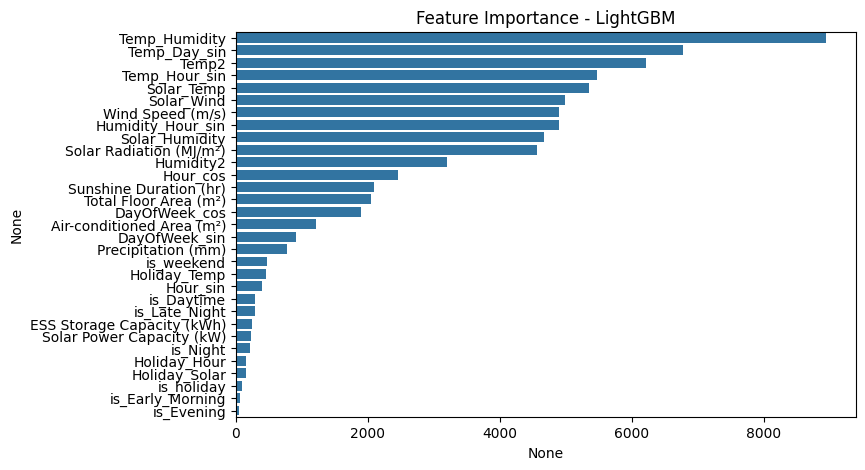

In [ ]:
# Index(['num_date_time', 'Building Number', 'Datetime', 'Temperature (°C)',
#        'Precipitation (mm)', 'Wind Speed (m/s)', 'Humidity (%)',
#        'Sunshine Duration (hr)', 'Solar Radiation (MJ/m²)',
#        'Power Consumption (kWh)', 'Hour', 'Day', 'Air-conditioned Area (m²)',
#        'Total Floor Area (m²)', 'Building Type', 'Solar Power Capacity (kW)',
#        'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)', 'DayOfWeek', 'Month',
#        'Week', 'is_weekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin',
#        'DayOfWeek_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos',
#        'Week_sin', 'Week_cos', 'is_Afternoon', 'is_Evening', 'is_Morning',
#        'is_Night', 'is_rain_light', 'is_rain_moderate', 'is_rain_heavy',
#        'is_cold', 'is_mild', 'is_hot', 'is_calm', 'is_breezy', 'is_windy',
#        'is_stormy', 'is_low_rad', 'is_medium_rad', 'is_high_rad',
#        'RollingMean_24h', 'RollingStd_24h', 'RollingMedian_24h',
#        'RollingMean_72h', 'RollingStd_72h', 'RollingMedian_72h',
#        'RollingMean_168h', 'RollingStd_168h', 'RollingMedian_168h',
#        'EWMA_24h'],
#       dtype='object')
  
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_school[['Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
            'is_weekend', 'is_Daytime', 'is_Early_Morning', 'is_Evening', 'is_Late_Night', 'is_Night',
            'Wind Speed (m/s)', 'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'Solar Power Capacity (kW)',
            'DayOfWeek_sin', 'DayOfWeek_cos', 'is_holiday',
            'Solar_Temp', 'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity',
            'Temp_Hour_sin', 'Temp_Day_sin', 'Humidity_Hour_sin', 'Holiday_Temp',
            'Holiday_Solar', 'Holiday_Hour', 'Temp2', 'Humidity2', 
            'Hour_sin', 'Hour_cos', 
                   ]]

y = train_school['Power Consumption (kWh)']

# ===== Train-test split =====    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM model =====
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=150,
    random_state=42
)

# Train (no 'verbose' here)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()




In [25]:
train.isna().sum()

num_date_time                     0
Building Number                   0
Datetime                          0
Temperature (°C)                  0
Precipitation (mm)                0
Wind Speed (m/s)                  0
Humidity (%)                      0
Sunshine Duration (hr)            0
Solar Radiation (MJ/m²)           0
Power Consumption (kWh)           0
Hour                              0
Day                               0
Air-conditioned Area (m²)         0
Total Floor Area (m²)             0
Building Type                     0
Solar Power Capacity (kW)         0
ESS Storage Capacity (kWh)        0
PCS Capacity (kW)                 0
DayOfWeek                         0
Month                             0
Week                              0
is_weekend                        0
Hour_sin                          0
Hour_cos                          0
DayOfWeek_sin                     0
DayOfWeek_cos                     0
Day_sin                           0
Day_cos                     

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# ===== 1️⃣ XGBoost =====
X = train_school[features]

y = train_school['Power Consumption (kWh)']

# ===== Train-test split =====    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100

print(f"XGBoost RMSE: {rmse_xgb:.2f}, R2: {r2_xgb:.4f}, MAPE: {mape_xgb:.2f}%")

# ===== 2️⃣ Random Forest =====
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf) * 100

print(f"Random Forest RMSE: {rmse_rf:.2f}, R2: {r2_rf:.4f}, MAPE: {mape_rf:.2f}%")




XGBoost RMSE: 188.25, R2: 0.9953, MAPE: 5.64%
Random Forest RMSE: 180.67, R2: 0.9957, MAPE: 4.89%


In [33]:
import pandas as pd


# # Convert to datetime first
# test_school['Datetime'] = pd.to_datetime(test_school['Datetime'], format='%Y%m%d %H')

# # Now extract the hour
# test_school['Hour'] = test_school['Datetime'].dt.hour
# test_school['Day'] = test_school['Datetime'].dt.day



# Features for prediction — must match training features
X_future = test_school[['Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
            'Sunshine Duration (hr)', 'Solar Radiation (MJ/m²)',
            'is_weekend', 'is_Daytime', 'is_Early_Morning', 'is_Evening', 'is_Late_Night', 'is_Night',
            'Wind Speed (m/s)', 'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'Solar Power Capacity (kW)',
            'DayOfWeek_sin', 'DayOfWeek_cos', 'is_holiday',
            'Solar_Temp', 'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity',
            'Temp_Hour_sin', 'Temp_Day_sin', 'Humidity_Hour_sin', 'Holiday_Temp',
            'Holiday_Solar', 'Holiday_Hour', 'Temp2', 'Humidity2', 
            'Hour_sin', 'Hour_cos', 
                   ]]
# Predict
test_school['Predicted Power Consumption (kWh)'] = model.predict(X_future)

# Save predictions
test_school.to_csv("school_predictions.csv", index=False)


C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\984280931.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_school['Predicted Power Consumption (kWh)'] = model.predict(X_future)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 19380, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2513.533192
LightGBM MSE: 11918.90
LightGBM RMSE: 109.17
LightGBM R2: 0.9943
LightGBM MAPE: 2.91%


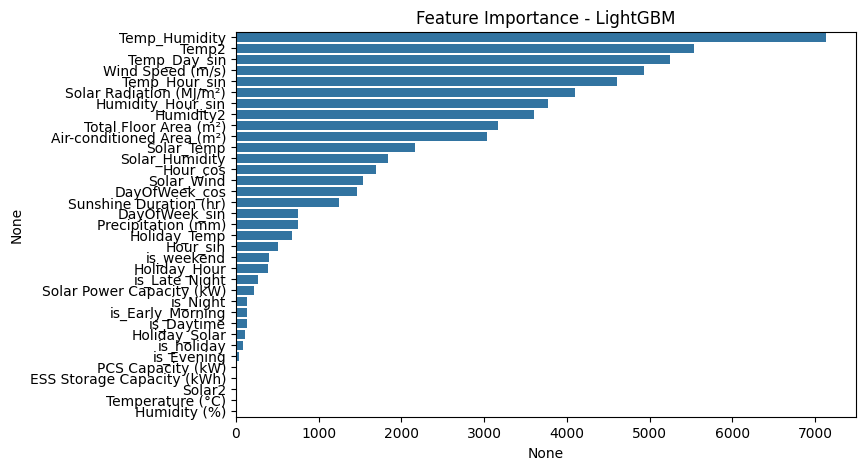

In [36]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_com[features]
y = train_com['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM model =====
model_com = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=300,
    learning_rate=0.1,
    num_leaves=200,
    random_state=42
)

# Train (no 'verbose' here)
model_com.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_com.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_com.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()


In [37]:
import pandas as pd


# # Convert to datetime first
# test_com['D'] = pd.to_datetime(test_com['Datetime'], format='%Y%m%d %H')

# # Now extract the hour
# test_com['Hour'] = test_com['Datetime'].dt.hour
# test_com['Day'] = test_com['Datetime'].dt.day



# Features for prediction — must match training features
X_future = test_com[features]

# Predict
test_com['Predicted Power Consumption (kWh)'] = model_com.predict(X_future)

# Save predictions
test_com.to_csv("commercial_predictions.csv", index=False)
df_new_com = pd.read_csv("commercial_predictions.csv")

df_new_com.head()


C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\852698115.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_com['Predicted Power Consumption (kWh)'] = model_com.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,2_20240825 00,2,2024-08-25 00:00:00,26.5,0.0,0.7,80.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1152.854086,1130.604835
1,2_20240825 01,2,2024-08-25 01:00:00,26.1,0.0,0.0,80.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1152.854086,934.436337
2,2_20240825 02,2,2024-08-25 02:00:00,25.9,0.0,0.3,83.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1152.854086,1069.487863
3,2_20240825 03,2,2024-08-25 03:00:00,25.7,0.0,1.1,83.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1152.854086,1027.885701
4,2_20240825 04,2,2024-08-25 04:00:00,25.5,0.0,1.0,86.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1152.854086,1040.734923


XGBoost MSE: 78564.21
XGBoost RMSE: 280.29
XGBoost R2: 0.9967
XGBoost MAPE: 1188437086008807680.00%


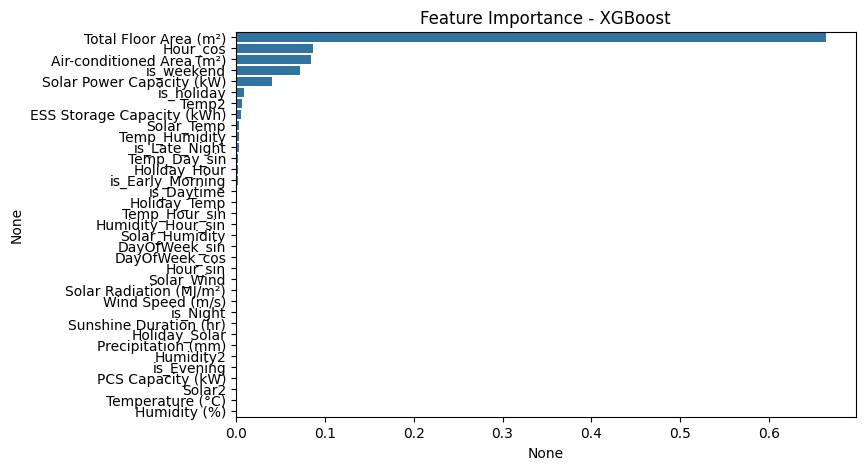

LightGBM Safe MAPE: 3.80%


In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ===== Prepare features & target =====
X = train_hospital[features]
y = train_hospital['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== XGBoost Regression model =====
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# ===== Predictions =====
y_pred = xgb_model.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost MSE: {mse:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R2: {r2:.4f}")
print(f"XGBoost MAPE: {mape:.2f}%")

# ===== Feature importance =====
feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - XGBoost")
plt.show()
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = safe_mape(y_test, y_pred)
print(f"LightGBM Safe MAPE: {mape:.2f}%")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3096
[LightGBM] [Info] Number of data points in the train set: 17442, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4456.881684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

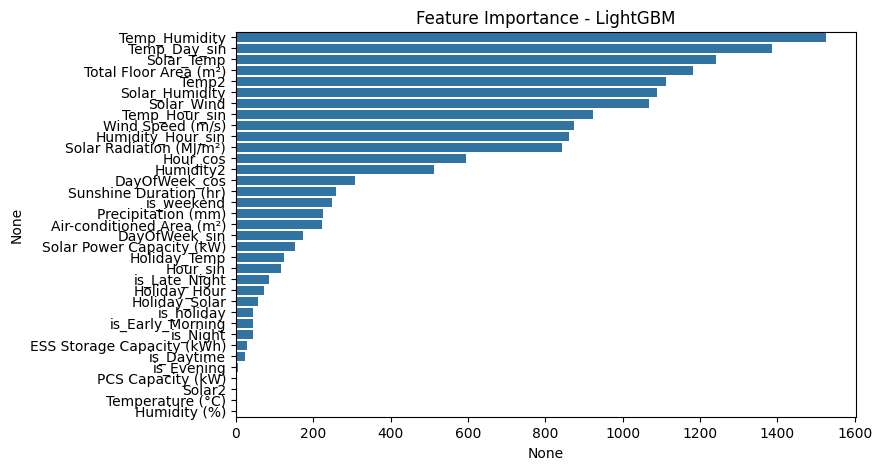

In [44]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== Prepare features & target =====
X = train_hospital[features]
y = train_hospital['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM Regression model =====
model_hospital = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=150,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# Train the model
model_hospital.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_hospital.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Safe MAPE to avoid division by zero
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = safe_mape(y_test, y_pred)

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM Safe MAPE: {mape:.2f}%")

# ===== Feature importance =====
feat_imp = pd.Series(model_hospital.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()


In [45]:
# Features for prediction — must match training features
X_future = test_hospital[features]
# Predict
test_hospital['Predicted Power Consumption (kWh)'] = model_hospital.predict(X_future)

# Save predictions
test_hospital.to_csv("hospital_predictions.csv", index=False)
df_new_hospital = pd.read_csv("hospital_predictions.csv")

df_new_hospital.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\2782358272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_hospital['Predicted Power Consumption (kWh)'] = model_hospital.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,3_20240825 00,3,2024-08-25 00:00:00,26.5,0.0,0.7,80.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13516.012534,13772.150865
1,3_20240825 01,3,2024-08-25 01:00:00,26.1,0.0,0.0,80.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13516.012534,13326.144018
2,3_20240825 02,3,2024-08-25 02:00:00,25.9,0.0,0.3,83.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13516.012534,14015.454799
3,3_20240825 03,3,2024-08-25 03:00:00,25.7,0.0,1.1,83.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13516.012534,13546.107258
4,3_20240825 04,3,2024-08-25 04:00:00,25.5,0.0,1.0,86.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13516.012534,14060.035605


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3042
[LightGBM] [Info] Number of data points in the train set: 18360, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2290.240326
LightGBM MSE: 117957.33
LightGBM RMSE: 343.45
LightGBM R2: 0.9752
LightGBM MAPE: 9.53%


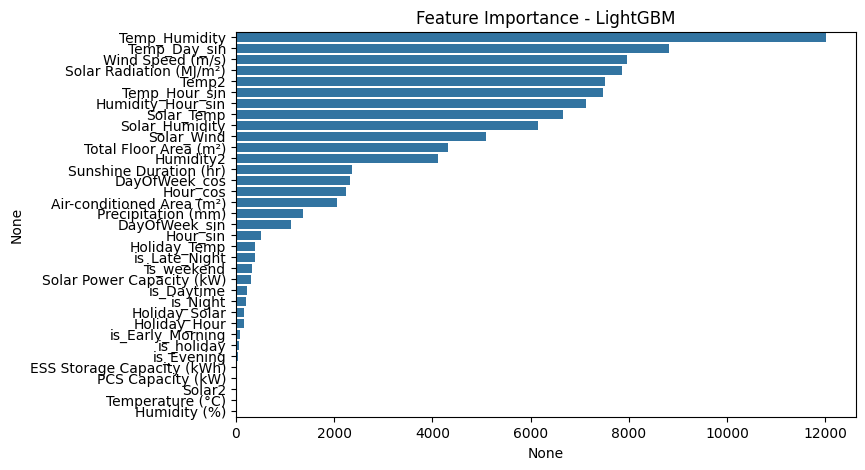

In [55]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_other[features]
y = train_other['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# ===== LightGBM model =====
model_other = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.09,
    num_leaves=200,
    random_state=42
)

# Train (no 'verbose' here)
model_other.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_other.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_other.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()


XGBoost MSE: 150849.00
XGBoost RMSE: 388.39
XGBoost R2: 0.9682
XGBoost MAPE: 10.53%


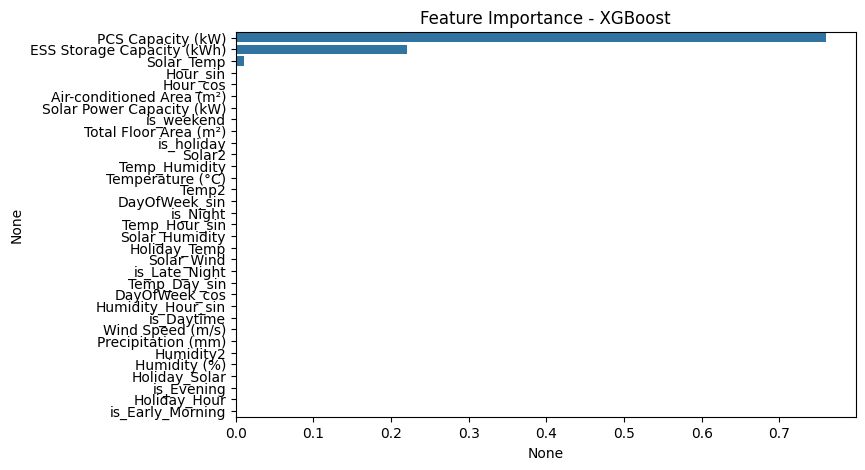

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Prepare features & target =====
X = train_other[features]
y = train_other['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# ===== XGBoost model =====
model_other = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.09,
    max_depth=8,        # Equivalent to LightGBM's num_leaves (approximate)
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",  # Faster training
    n_jobs=-1
)

# ===== Train the model =====
model_other.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# ===== Predictions =====
y_pred = model_other.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost MSE: {mse:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R2: {r2:.4f}")
print(f"XGBoost MAPE: {mape:.2f}%")

# ===== Feature importance =====
feat_imp = pd.Series(model_other.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - XGBoost")
plt.show()


In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======== Prepare features & target ========
X = train_other[features]
y = train_other['Power Consumption (kWh)']

# ======== Train-test split ========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# ======== Parameter grid ========
param_grid = {
    "colsample_bytree": [0.9, 0.9, 0.8, 0.9, 0.9],
    "gamma": [8.161415, 8.915918, 8.249356, 6.575258, 8.487247],
    "max_depth": [6, 5, 6, 6, 6],
    "min_child_weight": [47, 8, 30, 54, 77],
    "reg_alpha": [6.721675, 6.736361, 7.109872, 7.016596, 6.186162],
    "reg_lambda": [6.064121, 5.957454, 5.927528, 5.413840, 4.798086],
    "subsample": [1.0, 1.0, 1.0, 1.0, 1.0],
    "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25]  # You can adjust if needed
}

# ======== Define SMAPE function ========
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# ======== Choose one parameter set ========
i = 5 # <-- Change index from 0 to 4 to try different sets

params = {
    "colsample_bytree": param_grid["colsample_bytree"][i],
    "gamma": param_grid["gamma"][i],
    "max_depth": param_grid["max_depth"][i],
    "min_child_weight": param_grid["min_child_weight"][i],
    "reg_alpha": param_grid["reg_alpha"][i],
    "reg_lambda": param_grid["reg_lambda"][i],
    "subsample": param_grid["subsample"][i],
    "learning_rate": param_grid["learning_rate"][i],
    "n_estimators": 500,
    "random_state": 42,
    "objective": "reg:squarederror"
}

# ======== Train XGBoost model ========
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# ======== Predictions ========
y_pred = model.predict(X_test)

# ======== Metrics ========
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
smape_score = smape(y_test, y_pred)

print(f"XGBoost Params Index: {i}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape_score:.2f}%")

# ======== Feature Importance ========
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - XGBoost")
plt.show()


IndexError: list index out of range

Random Forest RMSE: 359.4339
Random Forest R²: 0.9728
Random Forest MAPE: 9.97%


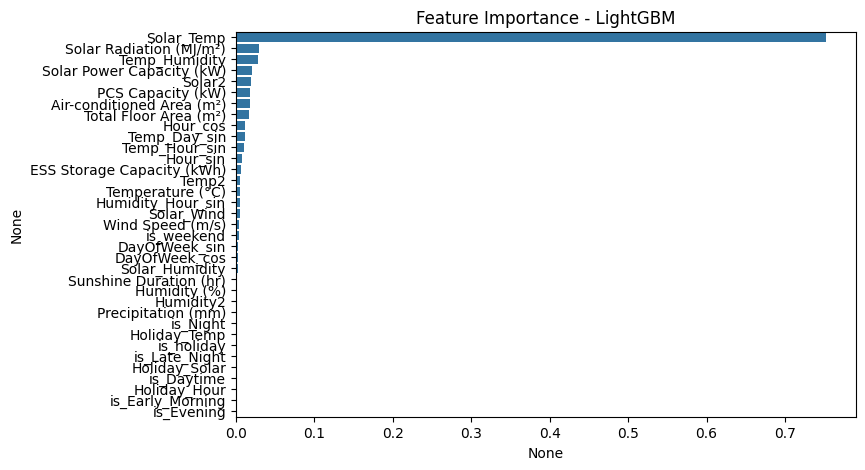

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # in percentage

print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest R²: {r2:.4f}")
print(f"Random Forest MAPE: {mape:.2f}%")
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()

In [56]:
# Features for prediction — must match training features
X_future = test_other[features]

# Predict
test_other['Predicted Power Consumption (kWh)'] = model_other.predict(X_future)

# Save predictions
test_other.to_csv("other_predictions.csv", index=False)
df_new_other = pd.read_csv("other_predictions.csv")

df_new_other.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\986456608.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_other['Predicted Power Consumption (kWh)'] = model_other.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,7_20240825 00,7,2024-08-25 00:00:00,26.5,0.0,0.7,80.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4864.376476,2465.696778
1,7_20240825 01,7,2024-08-25 01:00:00,26.1,0.0,0.0,80.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4864.376476,2181.898247
2,7_20240825 02,7,2024-08-25 02:00:00,25.9,0.0,0.3,83.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4864.376476,3458.698313
3,7_20240825 03,7,2024-08-25 03:00:00,25.7,0.0,1.1,83.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4864.376476,2630.676687
4,7_20240825 04,7,2024-08-25 04:00:00,25.5,0.0,1.0,86.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4864.376476,4055.739959


In [40]:
# # Features for prediction — must match training features
# X_future = test_other[['Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
#                   'is_weekend', 'is_Morning', 'is_Evening', 'is_Night', 'is_Afternoon',
#                   'Wind Speed (m/s)', 'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)', 'Solar Power Capacity (kW)',
#                   'DayOfWeek_sin', 'DayOfWeek_cos',
#                   'Hour_sin', 'Hour_cos', 'Temperature (°C)', 
#                    'Humidity (%)'
#                    ]]

# # Predict
# test_other['Predicted Power Consumption (kWh)'] = rf_model.predict(X_future)

# # Save predictions
# test_other.to_csv("other_predictions.csv", index=False)
# df_new_other = pd.read_csv("other_predictions.csv")

# df_new_other.head()

In [41]:
train.columns

Index(['num_date_time', 'Building Number', 'Datetime', 'Temperature (°C)',
       'Precipitation (mm)', 'Wind Speed (m/s)', 'Humidity (%)',
       'Sunshine Duration (hr)', 'Solar Radiation (MJ/m²)',
       'Power Consumption (kWh)', 'Hour', 'Day', 'Air-conditioned Area (m²)',
       'Total Floor Area (m²)', 'Building Type', 'Solar Power Capacity (kW)',
       'ESS Storage Capacity (kWh)', 'PCS Capacity (kW)', 'DayOfWeek', 'Month',
       'Week', 'is_weekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos',
       'Week_sin', 'Week_cos', 'is_Afternoon', 'is_Evening', 'is_Morning',
       'is_Night', 'is_rain_light', 'is_rain_moderate', 'is_rain_heavy',
       'is_cold', 'is_mild', 'is_hot', 'is_calm', 'is_breezy', 'is_windy',
       'is_stormy', 'is_low_rad', 'is_medium_rad', 'is_high_rad',
       'RollingMean_24h', 'RollingStd_24h', 'RollingMedian_24h',
       'RollingMean_72h', 'RollingStd_72h', 'RollingMedian_72h',
   

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 17442, number of used features: 27
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1106.531068
LightGBM MSE: 8905.31
LightGBM RMSE: 94.37
LightGBM R2: 0.9877
LightGBM MAPE: 309141113863687232.00%


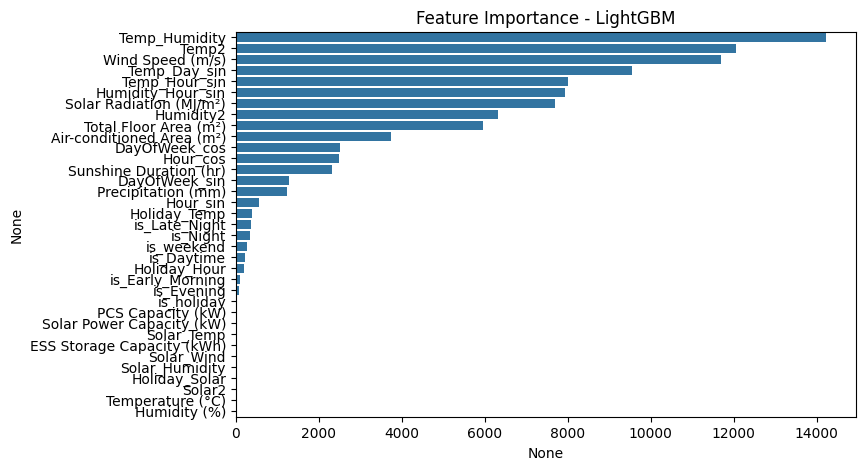

LightGBM Safe MAPE: 17.08%


In [58]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_apartment[features]
y = train_apartment['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM model =====
model_ap = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=200,
    random_state=42
)

# Train (no 'verbose' here)
model_ap.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_ap.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_ap.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = safe_mape(y_test, y_pred)
print(f"LightGBM Safe MAPE: {mape:.2f}%")


Random Forest MSE: 13897.50
Random Forest RMSE: 117.89
Random Forest R2: 0.9809
Random Forest Safe MAPE: 6.21%


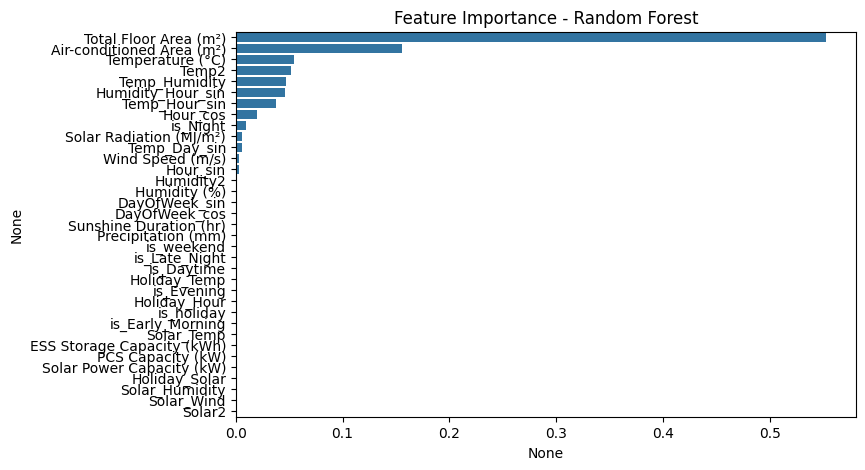

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Prepare features & target =====
X = train_apartment[features]
y = train_apartment['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== Random Forest model =====
rf_model_ap = RandomForestRegressor(
    n_estimators=400,        # number of trees
    max_depth=None,          # no max depth
    min_samples_split=2,     # minimum samples to split
    min_samples_leaf=1,      # minimum samples at leaf
    random_state=42,
    n_jobs=-1
)

# Train
rf_model_ap.fit(X_train, y_train)

# ===== Predictions =====
y_pred = rf_model_ap.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Safe MAPE function
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = safe_mape(y_test, y_pred)

print(f"Random Forest MSE: {mse:.2f}")
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R2: {r2:.4f}")
print(f"Random Forest Safe MAPE: {mape:.2f}%")

# ===== Feature importance =====
feat_imp = pd.Series(rf_model_ap.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - Random Forest")
plt.show()


In [61]:
# Features for prediction — must match training features
X_future = test_apartment[features]
# Predict
test_apartment['Predicted Power Consumption (kWh)'] = rf_model_ap.predict(X_future)

# Save predictions
test_apartment.to_csv("apartment_predictions.csv", index=False)
df_new_apartment = pd.read_csv("apartment_predictions.csv")

df_new_apartment.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\1127591273.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_apartment['Predicted Power Consumption (kWh)'] = rf_model_ap.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,11_20240825 00,11,2024-08-25 00:00:00,26.3,0.0,0.4,88.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1791.773094,1403.15340
1,11_20240825 01,11,2024-08-25 01:00:00,25.9,0.0,0.2,89.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1791.773094,1172.08785
2,11_20240825 02,11,2024-08-25 02:00:00,25.7,0.0,0.8,91.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1791.773094,1034.18925
3,11_20240825 03,11,2024-08-25 03:00:00,25.3,0.0,0.4,92.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1791.773094,923.35740
4,11_20240825 04,11,2024-08-25 04:00:00,25.1,0.0,0.8,93.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1791.773094,863.52630


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 17442, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2109.648492
LightGBM MSE: 68252.04
LightGBM RMSE: 261.25
LightGBM R2: 0.9293
LightGBM MAPE: 5.77%


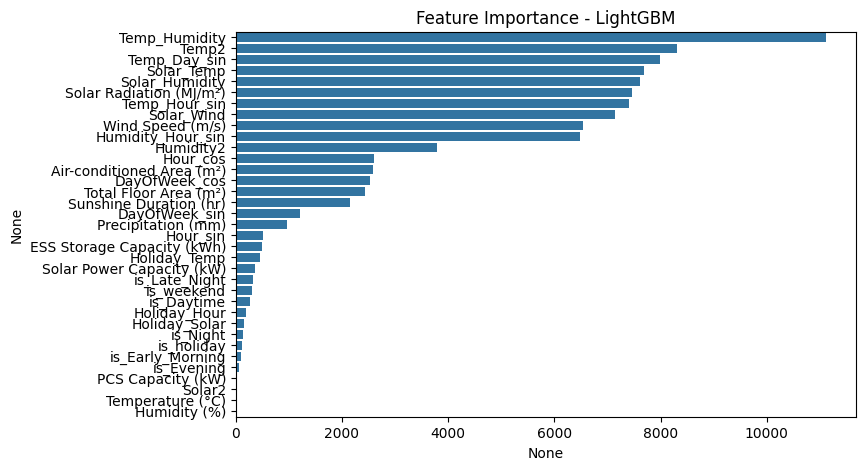

XGBoost MSE: 73742.71, RMSE: 271.56, R2: 0.9236, MAPE: 6.62%


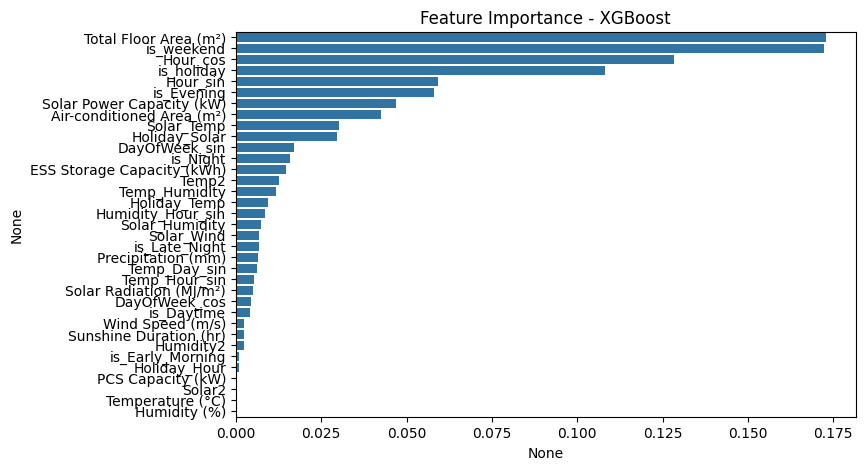

Random Forest MSE: 65522.88, RMSE: 255.97, R2: 0.9322, MAPE: 5.43%


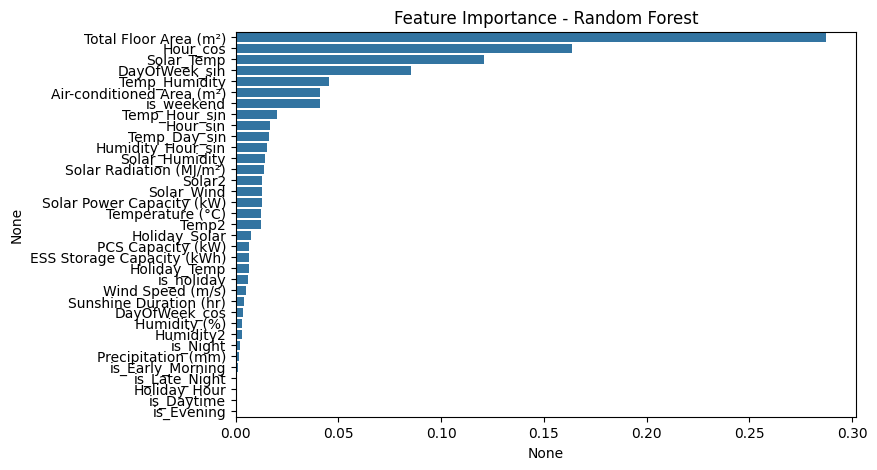

In [63]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_research[features]

y = train_research['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM model =====
model_r = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=200,
    random_state=42
)

# Train (no 'verbose' here)
model_r.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_r.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_r.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Features & Target =====
X = train_research[features]
y = train_research['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== XGBoost Regressor =====
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Metrics for XGB
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100
print(f"XGBoost MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")

# Feature importance
feat_imp_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp_xgb, y=feat_imp_xgb.index)
plt.title("Feature Importance - XGBoost")
plt.show()

# ===== Random Forest Regressor =====
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Metrics for RF
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)
mape = mean_absolute_percentage_error(y_test, y_pred_rf) * 100
print(f"Random Forest MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAPE: {mape:.2f}%")

# Feature importance
feat_imp_rf = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp_rf, y=feat_imp_rf.index)
plt.title("Feature Importance - Random Forest")
plt.show()


In [64]:
# Features for prediction — must match training features
X_future = test_research[features]

# Predict
test_research['Predicted Power Consumption (kWh)'] = rf_model.predict(X_future)

# Save predictions
test_research.to_csv("research_predictions.csv", index=False)
df_new_research = pd.read_csv("research_predictions.csv")

df_new_research.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\2542729365.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_research['Predicted Power Consumption (kWh)'] = rf_model.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,13_20240825 00,13,2024-08-25 00:00:00,26.3,0.0,0.4,88.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2190.265239,2033.7234
1,13_20240825 01,13,2024-08-25 01:00:00,25.9,0.0,0.2,89.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2190.265239,1995.5883
2,13_20240825 02,13,2024-08-25 02:00:00,25.7,0.0,0.8,91.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2190.265239,1978.6719
3,13_20240825 03,13,2024-08-25 03:00:00,25.3,0.0,0.4,92.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2190.265239,1970.7774
4,13_20240825 04,13,2024-08-25 04:00:00,25.1,0.0,0.8,93.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2190.265239,1916.8428


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3180
[LightGBM] [Info] Number of data points in the train set: 31008, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2731.764729
LightGBM MSE: 63177.43
LightGBM RMSE: 251.35
LightGBM R2: 0.9931
LightGBM MAPE: 8.41%


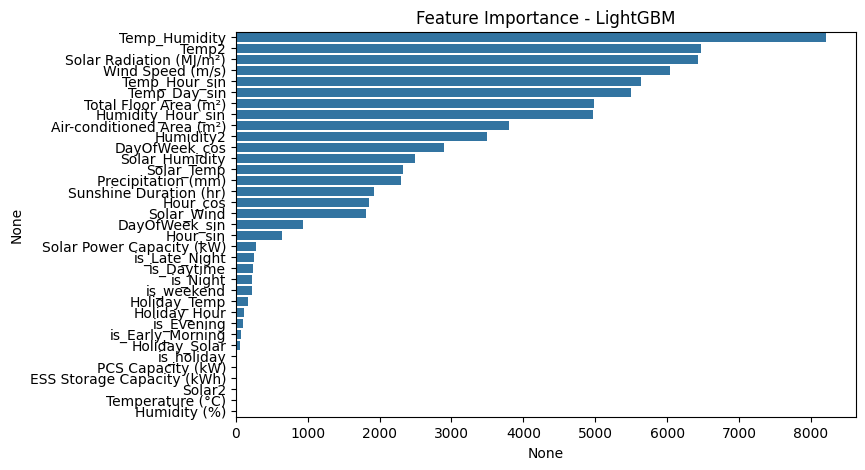

LightGBM Safe MAPE: 8.41%


In [66]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_department[features]
y = train_department['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM model =====
model_dep = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=150,
    random_state=42
)

# Train (no 'verbose' here)
model_dep.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_dep.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_dep.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = safe_mape(y_test, y_pred)
print(f"LightGBM Safe MAPE: {mape:.2f}%")


In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ===== Safe MAPE function =====
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== Model =====
rf_model_dep = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# ===== Train =====
rf_model_dep.fit(X_train, y_train)

# ===== Predict =====
y_pred = rf_model_dep.predict(X_test)

# ===== Metrics =====
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = safe_mape(y_test, y_pred)

print(f"Random Forest RMSE: {rmse:.4f}")
print(f"Random Forest R²: {r2:.4f}")
print(f"Random Forest Safe MAPE: {mape:.2f}%")


Random Forest RMSE: 252.7601
Random Forest R²: 0.9930
Random Forest Safe MAPE: 7.84%


XGBoost MSE: 82637.00
XGBoost RMSE: 287.47
XGBoost R2: 0.9910
XGBoost MAPE: 9.83%


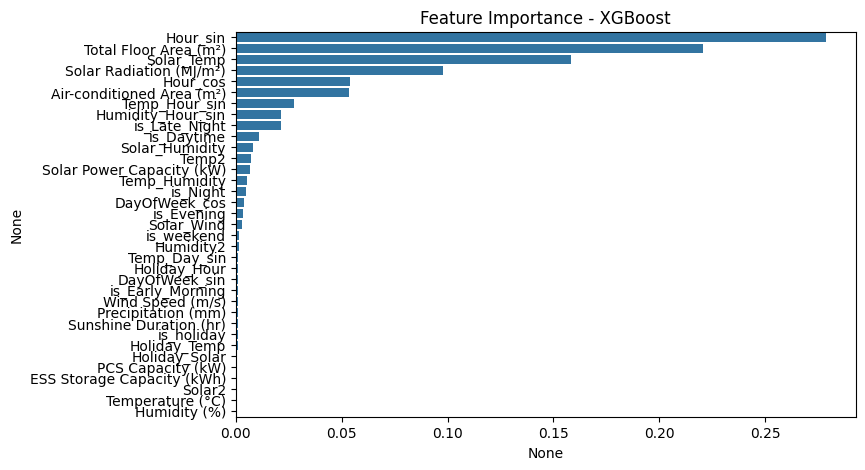

XGBoost Safe MAPE: 9.83%


In [68]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== XGBoost model =====
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100

print(f"XGBoost MSE: {mse:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R2: {r2:.4f}")
print(f"XGBoost MAPE: {mape:.2f}%")

# ===== Feature importance =====
feat_imp_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp_xgb, y=feat_imp_xgb.index)
plt.title("Feature Importance - XGBoost")
plt.show()

# ===== Safe MAPE =====
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

safe_mape_val = safe_mape(y_test, y_pred_xgb)
print(f"XGBoost Safe MAPE: {safe_mape_val:.2f}%")


In [69]:
# Features for prediction — must match training features
X_future = test_department[features]

# Predict
test_department['Predicted Power Consumption (kWh)'] = rf_model_dep.predict(X_future)

# Save predictions
test_department.to_csv("dept_predictions.csv", index=False)
df_new_dept = pd.read_csv("dept_predictions.csv")

df_new_dept.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\2214591296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_department['Predicted Power Consumption (kWh)'] = rf_model_dep.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,18_20240825 00,18,2024-08-25 00:00:00,25.0,0.0,0.2,90.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,617.776331,549.48276
1,18_20240825 01,18,2024-08-25 01:00:00,24.7,0.0,1.0,92.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,617.776331,537.98088
2,18_20240825 02,18,2024-08-25 02:00:00,24.3,0.0,0.9,94.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,617.776331,534.47472
3,18_20240825 03,18,2024-08-25 03:00:00,24.2,0.0,0.6,94.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,617.776331,529.01892
4,18_20240825 04,18,2024-08-25 04:00:00,23.9,0.0,0.7,95.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,617.776331,541.45152


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3021
[LightGBM] [Info] Number of data points in the train set: 17442, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 10320.203086
LightGBM MSE: 58148.67
LightGBM RMSE: 241.14
LightGBM R2: 0.9973
LightGBM MAPE: 1.58%


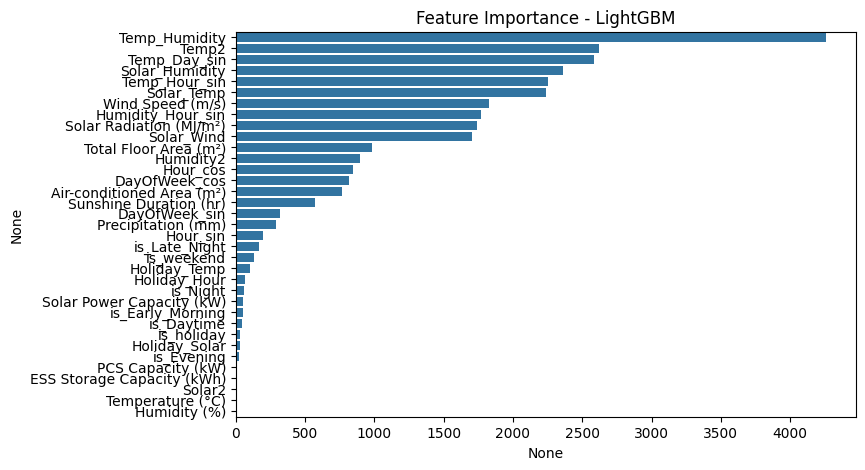

LightGBM Safe MAPE: 1.58%


In [70]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_idc[features]
y = train_idc['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM model =====
model_idc = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=150,
    random_state=42
)

# Train (no 'verbose' here)
model_idc.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_idc.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_idc.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = safe_mape(y_test, y_pred)
print(f"LightGBM Safe MAPE: {mape:.2f}%")


In [71]:
# Features for prediction — must match training features
X_future = test_idc[features]


# Predict
test_idc['Predicted Power Consumption (kWh)'] = model_idc.predict(X_future)

# Save predictions
test_idc.to_csv("idc_predictions.csv", index=False)
df_new_idc = pd.read_csv("idc_predictions.csv")

df_new_idc.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\3158913686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_idc['Predicted Power Consumption (kWh)'] = model_idc.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,30_20240825 00,30,2024-08-25 00:00:00,25.0,0.0,0.2,90.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9989.183765,9834.504306
1,30_20240825 01,30,2024-08-25 01:00:00,24.7,0.0,1.0,92.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9989.183765,9812.784169
2,30_20240825 02,30,2024-08-25 02:00:00,24.3,0.0,0.9,94.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9989.183765,9782.239071
3,30_20240825 03,30,2024-08-25 03:00:00,24.2,0.0,0.6,94.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9989.183765,9771.255005
4,30_20240825 04,30,2024-08-25 04:00:00,23.9,0.0,0.7,95.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9989.183765,9760.597605


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 15504, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1626.623051
LightGBM MSE: 24032.06
LightGBM RMSE: 155.02
LightGBM R2: 0.9602
LightGBM MAPE: 6.67%


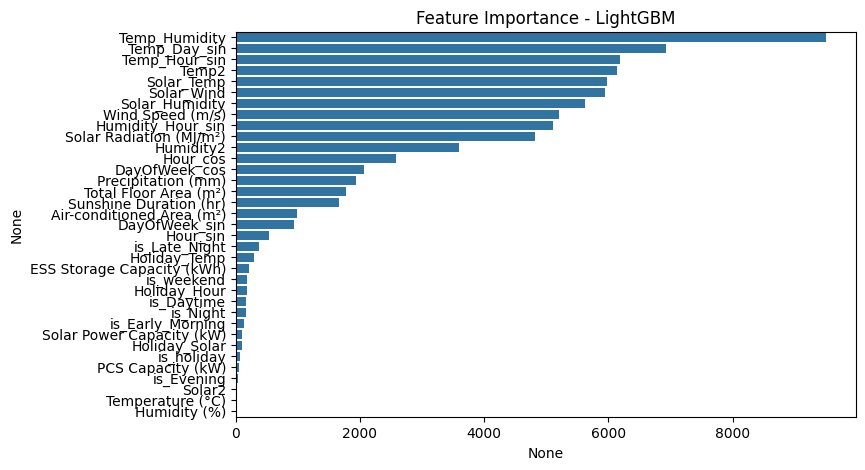

LightGBM Safe MAPE: 6.67%


In [72]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_public[features]
y = train_public['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM model =====
model_p = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=400,
    learning_rate=0.1,
    num_leaves=200,
    random_state=42
)

# Train (no 'verbose' here)
model_p.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_p.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_p.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = safe_mape(y_test, y_pred)
print(f"LightGBM Safe MAPE: {mape:.2f}%")


XGBoost MSE: 22997.79
XGBoost RMSE: 151.65
XGBoost R2: 0.9619
XGBoost MAPE: 6.36%
XGBoost Safe MAPE: 6.36%


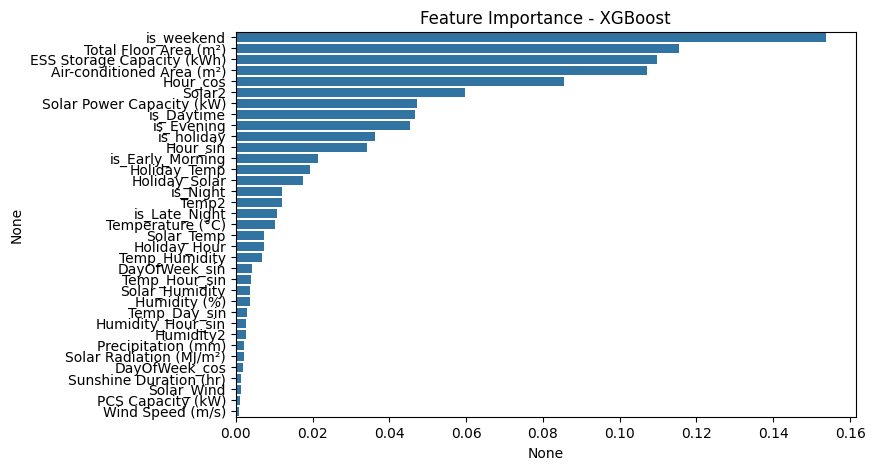

In [73]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Prepare features & target =====
X = train_public[features]
y = train_public['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== XGBoost model =====
model_xgb_dep = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',   # faster training
    enable_categorical=False
)

# Train
model_xgb_dep.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# ===== Predictions =====
y_pred = model_xgb_dep.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost MSE: {mse:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R2: {r2:.4f}")
print(f"XGBoost MAPE: {mape:.2f}%")

# ===== Safe MAPE =====
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

safe_mape_val = safe_mape(y_test, y_pred)
print(f"XGBoost Safe MAPE: {safe_mape_val:.2f}%")

# ===== Feature importance =====
feat_imp = pd.Series(model_xgb_dep.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - XGBoost")
plt.show()


Random Forest MSE: 24687.95
Random Forest RMSE: 157.12
Random Forest R2: 0.9591
Random Forest Safe MAPE: 6.06%



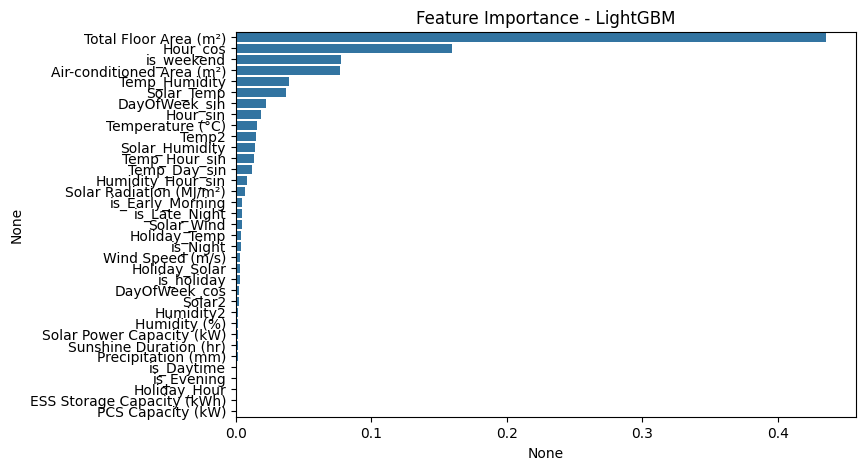

In [74]:

# ===== Random Forest =====
model_rf_public = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model_rf_public.fit(X_train, y_train)
y_pred_rf = model_rf_public.predict(X_test)

# ===== Metrics Function =====
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = safe_mape(y_true, y_pred)
    print(f"{name} MSE: {mse:.2f}")
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} R2: {r2:.4f}")
    print(f"{name} Safe MAPE: {mape:.2f}%\n")

# ===== Evaluate All =====
# evaluate_model("LightGBM", y_test, y_pred_lgb)
# evaluate_model("XGBoost", y_test, y_pred_xgb)
evaluate_model("Random Forest", y_test, y_pred_rf)

# ===== Feature Importance (LightGBM example) =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_rf_public.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()

In [75]:
# Features for prediction — must match training features
X_future = test_public[features]
# Predict
test_public['Predicted Power Consumption (kWh)'] = model_rf_public.predict(X_future)

# Save predictions
test_public.to_csv("public_predictions.csv", index=False)
df_new_public = pd.read_csv("public_predictions.csv")

df_new_public.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\2476412266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_public['Predicted Power Consumption (kWh)'] = model_rf_public.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,33_20240825 00,33,2024-08-25 00:00:00,26.5,0.0,0.7,80.0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,997.559999,1804.327950
1,33_20240825 01,33,2024-08-25 01:00:00,26.1,0.0,0.0,80.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,997.559999,1762.016675
2,33_20240825 02,33,2024-08-25 02:00:00,25.9,0.0,0.3,83.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,997.559999,1729.116800
3,33_20240825 03,33,2024-08-25 03:00:00,25.7,0.0,1.1,83.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,997.559999,1856.271300
4,33_20240825 04,33,2024-08-25 04:00:00,25.5,0.0,1.0,86.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,997.559999,1621.233725


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2588
[LightGBM] [Info] Number of data points in the train set: 19380, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3174.634556
LightGBM MSE: 228929.34
LightGBM RMSE: 478.47
LightGBM R2: 0.9728
LightGBM MAPE: 8.73%


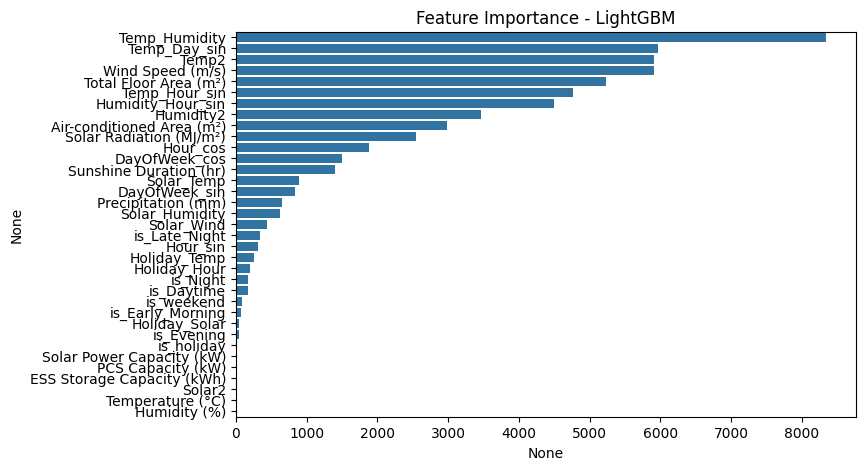

LightGBM Safe MAPE: 8.73%

===== XGBoost Results =====
MSE: 207942.01
RMSE: 456.01
R2: 0.9753
Safe MAPE: 8.51%

===== Random Forest Results =====
MSE: 235008.02
RMSE: 484.78
R2: 0.9721
Safe MAPE: 7.85%


In [76]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# ===== Prepare features & target =====
X = train_hotel[features]
y = train_hotel['Power Consumption (kWh)']

# ===== Train-test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# ===== LightGBM model =====
model_hotel = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=400,
    learning_rate=0.1,
    num_leaves=150,
    random_state=42
)

# Train (no 'verbose' here)
model_hotel.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# ===== Predictions =====
y_pred = model_hotel.predict(X_test)

# ===== Metrics =====
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # %

print(f"LightGBM MSE: {mse:.2f}")
print(f"LightGBM RMSE: {rmse:.2f}")
print(f"LightGBM R2: {r2:.4f}")
print(f"LightGBM MAPE: {mape:.2f}%")

# ===== Feature importance =====
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model_hotel.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - LightGBM")
plt.show()
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

mape = safe_mape(y_test, y_pred)
print(f"LightGBM Safe MAPE: {mape:.2f}%")

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# ===== XGBoost =====
model_xgb = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"   # faster, try "gpu_hist" if GPU is available
)

model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred_xgb = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = safe_mape(y_test, y_pred_xgb)

print("\n===== XGBoost Results =====")
print(f"MSE: {mse_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R2: {r2_xgb:.4f}")
print(f"Safe MAPE: {mape_xgb:.2f}%")

# ===== Random Forest =====
model_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = safe_mape(y_test, y_pred_rf)

print("\n===== Random Forest Results =====")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R2: {r2_rf:.4f}")
print(f"Safe MAPE: {mape_rf:.2f}%")



In [77]:
# Features for prediction — must match training features
X_future = test_hotel[features]

# Predict
test_hotel['Predicted Power Consumption (kWh)'] = model_rf.predict(X_future)

# Save predictions
test_hotel.to_csv("hotel_predictions.csv", index=False)
df_new_hotel = pd.read_csv("hotel_predictions.csv")

df_new_hotel.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_9380\553890332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_hotel['Predicted Power Consumption (kWh)'] = model_rf.predict(X_future)


,num_date_time,Building Number,Datetime,Temperature (°C),Precipitation (mm),Wind Speed (m/s),Humidity (%),Sunshine Duration (hr),Solar Radiation (MJ/m²),Hour,...,RollingStd_24h,RollingMedian_24h,RollingMean_72h,RollingStd_72h,RollingMedian_72h,RollingMean_168h,RollingStd_168h,RollingMedian_168h,EWMA_24h,Predicted Power Consumption (kWh)
0,1_20240825 00,1,2024-08-25 00:00:00,26.5,0.0,0.7,80.0,0.0,0.0,0,...,815.233028,2537.1,2176.617917,693.70539,2141.22,2171.638393,615.448296,2191.5,2519.046981,4969.288050
1,1_20240825 01,1,2024-08-25 01:00:00,26.1,0.0,0.0,80.0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2519.046981,4897.944375
2,1_20240825 02,1,2024-08-25 02:00:00,25.9,0.0,0.3,83.0,0.0,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2519.046981,4225.328325
3,1_20240825 03,1,2024-08-25 03:00:00,25.7,0.0,1.1,83.0,0.0,0.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2519.046981,4047.343725
4,1_20240825 04,1,2024-08-25 04:00:00,25.5,0.0,1.0,86.0,0.0,0.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2519.046981,3907.995900


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- SMAPE Function ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# === Choose one building ===
building_number = 1234  # <-- Change this to your building number

# Filter data for this building
bld_train = train_other[train_other['Building Number'] == building_number]

# === Features & Target ===
X = bld_train[['Total Floor Area (m²)', 'Air-conditioned Area (m²)', 
        'is_weekend', 'is_Daytime', 'is_Early_Morning', 'is_Evening', 
        'is_Late_Night', 'is_Night', 'Wind Speed (m/s)', 
        'Precipitation (mm)', 'ESS Storage Capacity (kWh)', 'Solar Power Capacity (kW)',
        'DayOfWeek_sin', 'DayOfWeek_cos', 'is_holiday', 'Solar_Temp', 
        'Solar_Humidity', 'Solar_Wind', 'Temp_Humidity', 'Temp_Hour_sin', 
        'Temp_Day_sin', 'Humidity_Hour_sin', 'Holiday_Temp', 'Holiday_Solar', 
        'Holiday_Hour', 'Temp2', 'Humidity2', 'Hour_sin', 'Hour_cos']]

y = bld_train['Power Consumption (kWh)']

# === Train-test split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === LightGBM Model ===
model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.08,
    num_leaves=120,
    random_state=42
)

# Train model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# === Predictions ===
y_pred = model.predict(X_val)

# === Metrics ===
building_smape = smape(y_val.values, y_pred)
building_mape = mean_absolute_percentage_error(y_val, y_pred) * 100

print(f"Building Number: {building_number}")
print(f"SMAPE: {building_smape:.2f}%")
print(f"MAPE: {building_mape:.2f}%")


In [78]:
import pandas as pd

# Load your submission once
submission_df = pd.read_csv('sample_submission.csv')

def update_submission_with_test(submission_df, test_file_path, power_col_name='Predicted Power Consumption (kWh)'):
    # Load the current test file
    test_df = pd.read_csv(test_file_path)
    
    # Create a dict mapping from num_date_time to power consumption
    update_map = dict(zip(test_df['num_date_time'], test_df[power_col_name]))
    
    # Update submission_df answer only for matching num_date_time keys
    submission_df['answer'] = submission_df.apply(
        lambda row: update_map.get(row['num_date_time'], row['answer']),
        axis=1
    )
    return submission_df

# Example of updating submission incrementally:
test_files = ['hotel_predictions.csv', 'apartment_predictions.csv', 'commercial_predictions.csv', 'dept_predictions.csv',
              'hospital_predictions.csv', 'idc_predictions.csv', 'other_predictions.csv', 'public_predictions.csv',
              'research_predictions.csv', 'school_predictions.csv']  

for test_file in test_files:
    submission_df = update_submission_with_test(submission_df, test_file)

# Save the final updated submission
submission_df.to_csv('updated_submission.csv', index=False)
